In [1]:
import math
import pandas as pd
import numpy as np
import nltk
import matplotlib.pyplot as plt
import praw
from nltk.sentiment.vader import SentimentIntensityAnalyzer as SIA
import label_data
from pprint import pprint
import os
import enchant
import string
import seaborn as sns 
import label_data
import pickle
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix

/home/benhc/anaconda2/lib/python2.7/site-packages/nltk/twitter/__init__.py:20: UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.
  warnings.warn("The twython library has not been installed. "


In [15]:
# Reddit API, put your own API details here (easily avialable from Reddit website)
reddit = praw.Reddit(client_id='YOUR_ID',
                     client_secret='YOUR_SECRET',
                     user_agent='YOUR_USERNAME')

In [16]:
# Remove duplicates 
headlines=set()

In [17]:
# Populate headlines
for submission in reddit.subreddit('bitcoin').new(limit=None):
    headlines.add(submission.title)

In [19]:
# Remove non English headlines by checking if mostly English words in the headline. 
engdict = enchant.Dict('en_GB')
removed_headlines = []
for h in headlines.copy():
    words = h.split(" ")
    total_length = len(words)
    english_words = sum([(engdict.check(w.translate(string.punctuation)) | w.isdigit()) for w in words])
    if (english_words/float(total_length)) <=0.3:
        removed_headlines.append(h)
        headlines.remove(h)    

In [20]:
# Get the polarity scores for the headlines
sia = SIA()
results = []

for line in headlines:
    pol_score = sia.polarity_scores(line)
    pol_score['headline'] = line
    results.append(pol_score)

In [22]:
# Put into dataframe and drop everything but headline and score
df = pd.DataFrame.from_records(results)
df.drop(columns = ['neg', 'pos', 'neu'], inplace = True)
df.head()

,compound,headline
0,0.0000,SEC Issues Order of Suspension of Trading in B...
1,0.0000,Sons of Satoshi
2,0.0000,"Daily Discussion, September 04, 2018"
3,0.3818,Benefits of Bitcoin
4,0.4019,Bitcoin Adoption Is Getting A Massive Lightnin...


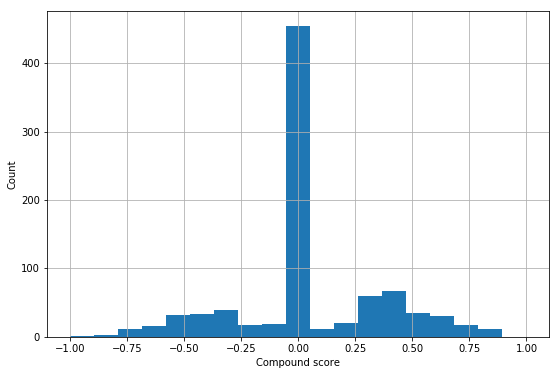

In [39]:
# Show the distribution of labelling 
fig, ax = plt.subplots(figsize=(9, 6))
df.hist(bins=np.linspace(-1, 1, 20), ax=ax)
ax.set_title('')
ax.set_xlabel('Compound score')
ax.set_ylabel('Count');

In [101]:
# Save the data to be labelled using label_data.py
df[0:200].to_pickle('Data/headlines.p')
# Now use `python label_data.py`

If you don't want to use reddit API or label, here you can load a pre-labelled data set

In [2]:
# Here's one I did earlier - load the labelled data 
df = pd.read_pickle('Data/labelled_headlines.p')
data = df['headline']

In [3]:
# Let's use some value to classify to the labels.
df['calc_label'] = 0
df.loc[df['compound'] > 0.2, 'calc_label'] = 1
df.loc[df['compound'] < -0.2, 'calc_label'] = -1

print("Positive headlines:\n")
pprint(list(df[df['calc_label'] == 1].headline)[:5], width=200)

print("\nNegative headlines:\n")
pprint(list(df[df['calc_label'] == -1].headline)[:5], width=200)

Positive headlines:

[u'Investing In Crypto Is As Easy As 1, 2, 3',
 u'Suggestions for advertising my website now accepts Bitcoin?',
 u'30% of all the websites use Wordpress. And they can accept BTC in 5 min - Direct to wallet| Permissionless - Just like Bitcoin',
 u'Can matcha make me do better TA and rich then?',
 u'One of the Richest BTC Address Removed 11589 BTC']

Negative headlines:

[u'Hyping Crypto is a Waste of Time',
 u'Bitcoin \u201cultimately failed as a currency\u201d: Weiss Ratings',
 u'How do I move my Bitcoin from Binance to Infinito Wallet. I\'m struggling with the "memo" part',
 u'SEC Decided To \u2018Review\u2019 Its Decision on Bitcoin ETF Rejections',
 u'2020 block halving could be massive for bitcoin price. Maybe 10,000,000 by 2023 trend chart predicts.']


In [5]:
# Check how the number of labels match up - k = neutral
df.groupby('label')['compound'].count()

label
k    131
n     35
p     34
Name: compound, dtype: int64

In [4]:
df.groupby('calc_label')['compound'].count()

calc_label
-1     37
 0    114
 1     49
Name: compound, dtype: int64

In [23]:
# We want a confusion matrix to understand whats happening better. 
def normalised_confusion_matrix(true, pred, ticklabels):
    """ Helper function to plot normalised confusion matrix """
    cm = confusion_matrix(true, pred)
    cm = cm/cm.astype(np.float).sum(axis=1).reshape(-1, 1)
    ax = plt.subplot()
    sns.heatmap(cm, annot=True, ax=ax)  
    ax.set_xlabel('Predicted')
    ax.set_ylabel('True')
    ax.xaxis.set_ticklabels(ticklabels)
    ax.yaxis.set_ticklabels(ticklabels)

[[18 13  4]
 [14 88 29]
 [ 5 13 16]]
[ 35. 131.  34.]
[[0.51428571 0.37142857 0.11428571]
 [0.10687023 0.67175573 0.22137405]
 [0.14705882 0.38235294 0.47058824]]


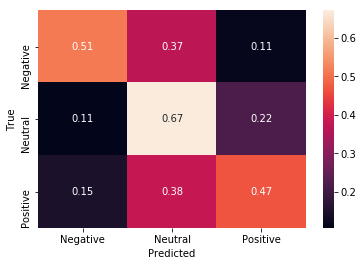

In [24]:
# Make the confusion matrix
true = df['label'].map({'k':0, 'p':1, 'n':-1})
pred = df['calc_label']
ticklabels = ['Negative', 'Neutral', 'Positive']
normalised_confusion_matrix(true, pred, ticklabels)

In [31]:
# Carry out the logistic regression on just the positive and negative results out of interest. 

df = pd.read_pickle('Data/labelled_headlines.p')
df = df[df['label']!='k']
df['label'] = df['label'].map({'n':0, 'p':1})

LogReg = LogisticRegression()
x = df['compound'].values.reshape(-1, 1)
y = df['label'].values.reshape(-1, 1)

LogReg.fit(x, y)
LogReg.score(x, y)


/home/benhc/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0.6811594202898551

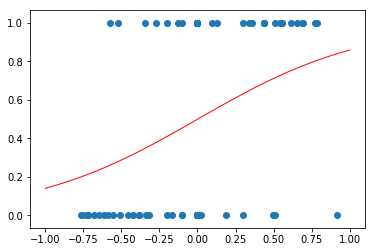

In [32]:
# Take a look at what the regression looks like.

plt.scatter(df['compound'], df['label'])

x = np.linspace(-1, 1)

def model(x):
    return 1 / (1 + np.exp(-x))

loss = model(x * LogReg.coef_ + LogReg.intercept_).ravel()
plt.plot(x, loss, color='red', linewidth=1)

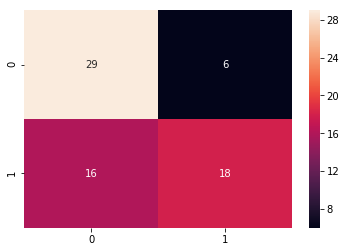

In [33]:
sns.heatmap(confusion_matrix(df['label'], LogReg.predict(df['compound'].values.reshape(-1, 1))), annot=True);